In [124]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
import re
import ast
from nltk.corpus import stopwords
import pickle
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
df = pd.read_csv('scrapped_data.csv')
df.tail()

,question_id,title,content,difficulty,likes,dislikes,similar_questions,topic_tags,stats,hints,topic
2214,1377,Number of Comments per Post,NaN,Easy,121,384,[],"[{'name': 'Database', 'slug': 'database', 'tra...","{""totalAccepted"": ""25.2K"", ""totalSubmission"": ...",[],Database
2215,949,Cat and Mouse,<p>A game on an <strong>undirected</strong> gr...,Hard,614,110,"[{""title"": ""Cat and Mouse II"", ""titleSlug"": ""c...","[{'name': 'Math', 'slug': 'math', 'translated_...","{""totalAccepted"": ""14.6K"", ""totalSubmission"": ...",[],Algorithms
2216,52,N-Queens II,<p>The <strong>n-queens</strong> puzzle is the...,Hard,1638,209,"[{""title"": ""N-Queens"", ""titleSlug"": ""n-queens""...","[{'name': 'Backtracking', 'slug': 'backtrackin...","{""totalAccepted"": ""214.4K"", ""totalSubmission"":...",[],Algorithms
2217,2135,Maximum Number of Ways to Partition an Array,<p>You are given a <strong>0-indexed</strong> ...,Hard,264,23,"[{""title"": ""Partition Equal Subset Sum"", ""titl...","[{'name': 'Array', 'slug': 'array', 'translate...","{""totalAccepted"": ""4.7K"", ""totalSubmission"": ""...",['A pivot point splits the array into equal pr...,Algorithms
2218,1321,Get Equal Substrings Within Budget,<p>You are given two strings <code>s</code> an...,Medium,624,43,[],"[{'name': 'String', 'slug': 'string', 'transla...","{""totalAccepted"": ""28.2K"", ""totalSubmission"": ...",['Calculate the differences between a[i] and b...,Algorithms


In [126]:
df.shape

(2219, 11)

In [127]:
#count of null values in each column
df.isnull().sum()

question_id            0
title                  0
content              464
difficulty             0
likes                  0
dislikes               0
similar_questions      0
topic_tags             0
stats                  0
hints                  0
topic                  0
dtype: int64

In [128]:
#check for duplicate questions in the dataset
# observation- no duplicates as the number of the rows in the dataset is equal to number of unique questions ids
df['question_id'].nunique()

2219

Medium    1184
Easy       556
Hard       479
Name: difficulty, dtype: int64


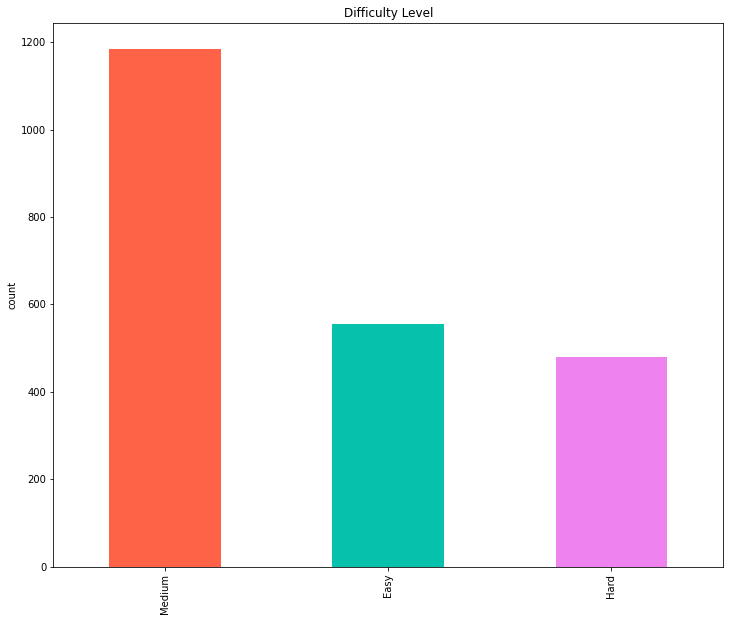

In [129]:
#count of questions based on difficult level
x = df['difficulty'].value_counts()
print(x)
colors = ['#FF6347', '#06C2AC','#EE82EE']
fig_dims = (12, 10)
fig, ax = plt.subplots(figsize=fig_dims)
x.plot(kind = 'bar',
       title = 'Difficulty Level',
       ylabel='count',
       color = colors,
       ax=ax)
plt.show()

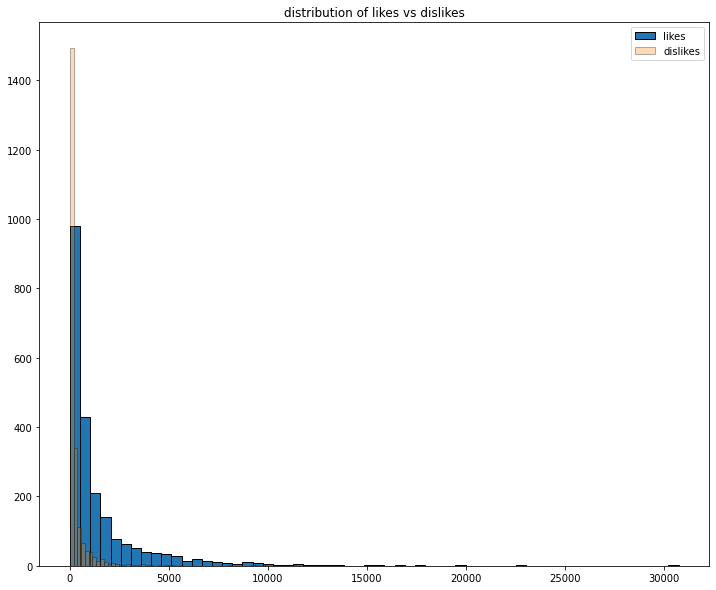

In [130]:
#Observation - Both the distributions are highly skewed

#likes
x = df['likes']
#dislikes
y = df['dislikes']

fig_dims = (12, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.hist(x, bins= 60, label='likes',  edgecolor = 'black')
plt.hist(y, bins=60, alpha=0.3, label='dislikes',  edgecolor = 'black')
plt.legend()
plt.title('distribution of likes vs dislikes')
plt.show()

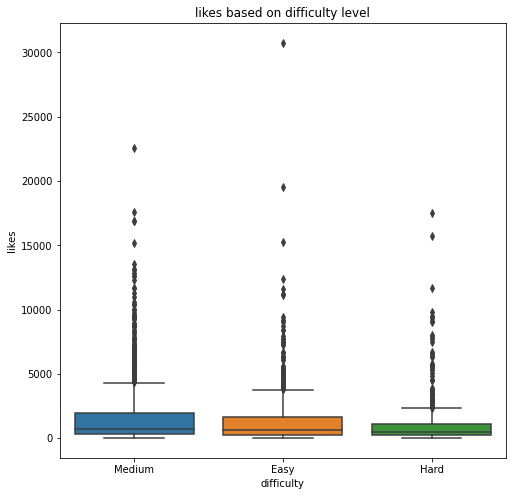

In [131]:
#likes based on difficulty level
y = df['likes']
x = df['difficulty']
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('likes based on difficulty level')
sns.boxplot(x = x, y = y, ax=ax)
plt.show()

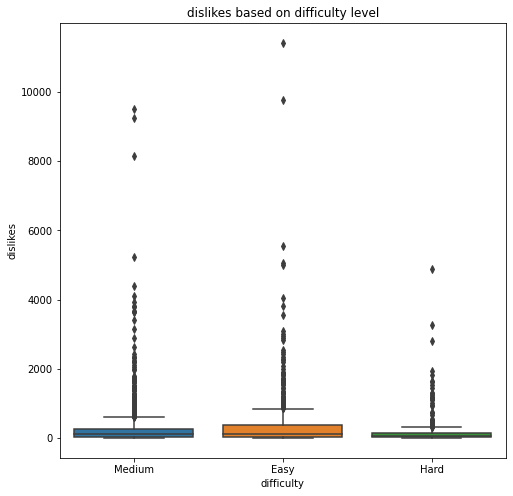

In [132]:
#dislikes based on difficulty level
y = df['dislikes']
x = df['difficulty']
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('dislikes based on difficulty level')
sns.boxplot(x = x, y = y, ax=ax)
plt.show()

In [133]:
#stats consist of multiple values 
df['stats'][1]

'{"totalAccepted": "39.8K", "totalSubmission": "56.9K", "totalAcceptedRaw": 39828, "totalSubmissionRaw": 56938, "acRate": "69.9%"}'

In [134]:
#changing stats into 4 seperate columns(each key as a seperate column)

#changing dtype of stats column from str to dict
for i in range(len(df)):
    # using ast.literal_eval() method
    df['stats'][i] = ast.literal_eval(df['stats'][i])

#changing each key of dictionary to a column in the dataframe
df = pd.concat([df, df["stats"].apply(pd.Series)], axis=1)
df.drop('stats',axis=1,inplace=True)

In [135]:
#replacing K(thousand) & M(million)  with their respective numeric values and changing dtypes to numeric
df["totalAccepted"] = df["totalAccepted"].replace({"K":"*1e3", "M":"*1e6"}, regex=True).map(pd.eval).astype(int)
df["totalSubmission"] = df["totalSubmission"].replace({"K":"*1e3", "M":"*1e6"}, regex=True).map(pd.eval).astype(int)

In [136]:
#checking for data error
#check if number of accepted sol > no of submitted solution
df[df['totalAccepted']>df['totalSubmission']]  #turned out to be null

,question_id,title,content,difficulty,likes,dislikes,similar_questions,topic_tags,hints,topic,totalAccepted,totalSubmission,totalAcceptedRaw,totalSubmissionRaw,acRate


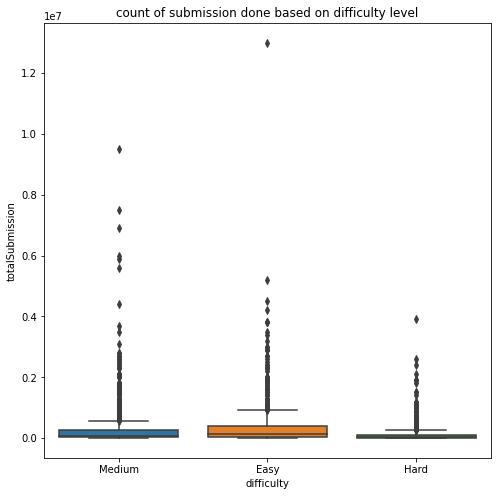

In [137]:
#count of submission are comparatively lower for hard questions
#count of submission done based on difficulty level
y = df['totalSubmission']
x = df['difficulty']
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('count of submission done based on difficulty level')
sns.boxplot(x = x, y = y, ax=ax)
plt.show()

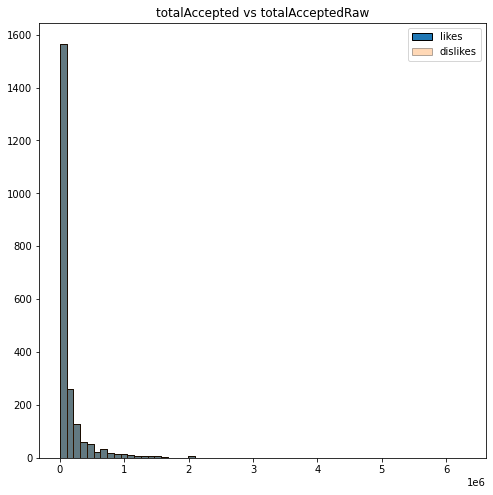

In [138]:
#distribution plots of totalAccepted and totalAcceptedRaw
x = df['totalAccepted']
y = df['totalAcceptedRaw']

fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.hist(x, bins= 60, label='likes',  edgecolor = 'black')
plt.hist(y, bins=60, alpha=0.3, label='dislikes',  edgecolor = 'black')
plt.legend()
plt.title('totalAccepted vs totalAcceptedRaw')
plt.show()

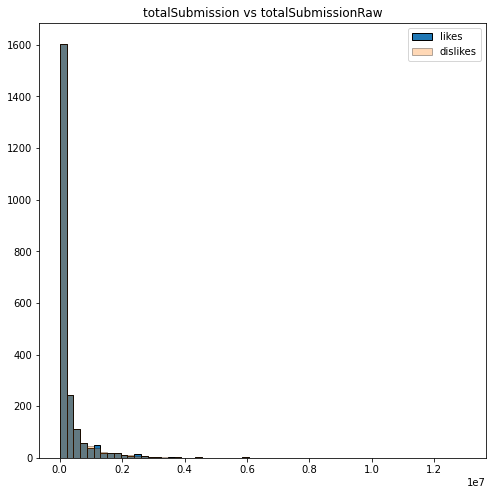

In [139]:
#distribution plots of totalSubmission and totalSubmissionRaw
x = df['totalSubmission']
y = df['totalSubmissionRaw']

fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.hist(x, bins= 60, label='likes',  edgecolor = 'black')
plt.hist(y, bins=60, alpha=0.3, label='dislikes',  edgecolor = 'black')
plt.legend()
plt.title('totalSubmission vs totalSubmissionRaw')
plt.show()

In [140]:
# Observation - since the distribution of both the features is exactly same we can drop any two of them as they are redundant
#droppping totalAcceptedRaw and totalSubmissionRaw
df.drop(['totalAcceptedRaw', 'totalSubmissionRaw'], axis=1, inplace=True)

In [141]:
##replacing % with empty character and change dtype to float
#ac rate is the success rate that is total accepted solution to total submissions made
df['acRate'] = df['acRate'].str.replace('%', '')
df['acRate'] = df['acRate'].astype('float')

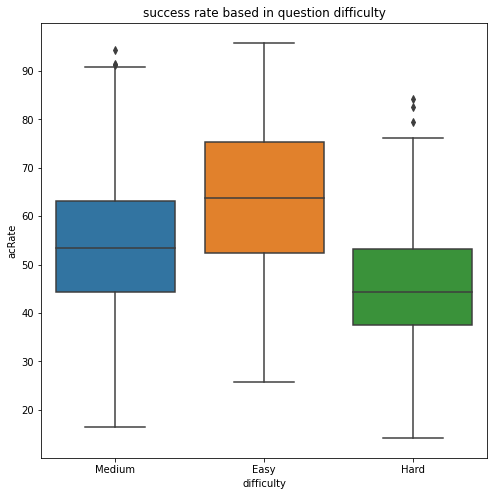

In [142]:
#observation - easy questions have a compartitvely higher acRate then other questions()
#acRate based in question difficulty
y = df['acRate']
x = df['difficulty']
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('success rate based in question difficulty')
sns.boxplot(x = x, y = y, ax=ax)
plt.show()

# Topic Tags

In [143]:
#converting the data into list of unique tags assoicated with each question
tags_lst=[] 
#iterating over every element of df
for i in range(len(df)):
    #change topic_tags to list of dict
    df['topic_tags'][i] =eval(df['topic_tags'][i])
    tag = []
    #check list length
    if len(df['topic_tags'][i])<1:
        tag.append('')
    else:
        #iterate over len of list
        for j in range(len(df['topic_tags'][i])):
            #extract value corresponding to the name key(tag)
            tag.append(df['topic_tags'][i][j]['name'])
    #append the list of tags into a single list
    tags_lst.append(tag)
df['topic_tags'] = tags_lst

In [144]:
#convert list of tags to string of tags
for i in range(len(df['topic_tags'])):
    tag_str = ' '.join(df['topic_tags'][i])
    df['topic_tags'][i]  = tag_str

In [145]:
#number of unique tags in the data
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(df['topic_tags'])
print("Number of unique tags :", tag_dtm.shape[1])

Number of unique tags : 92


[]

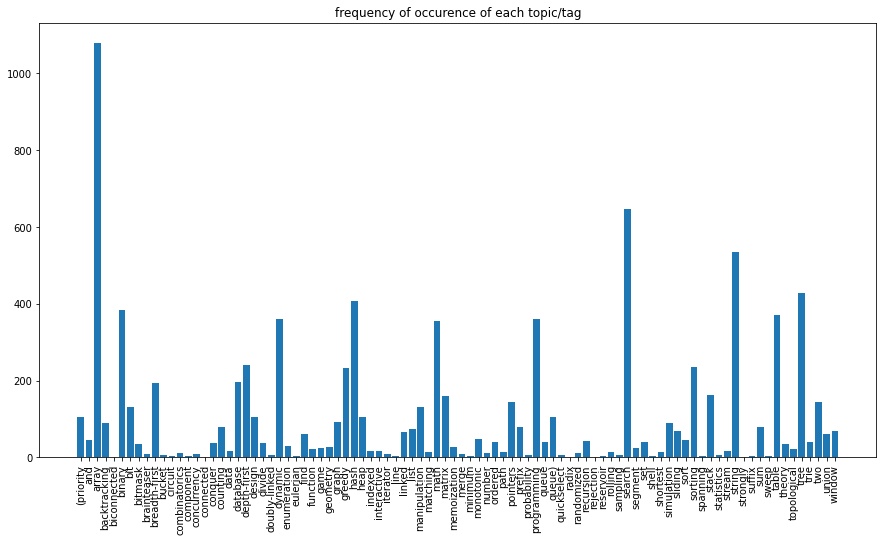

In [146]:
#frequency of occurence of each topics/tags
tags = vectorizer.get_feature_names()
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))
fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.bar(range(len(result)), list(result.values()), align='center')
plt.xticks(range(len(result)), list(result.keys()), rotation = 90)
plt.title('frequency of occurence of each topic/tag')
plt.plot()

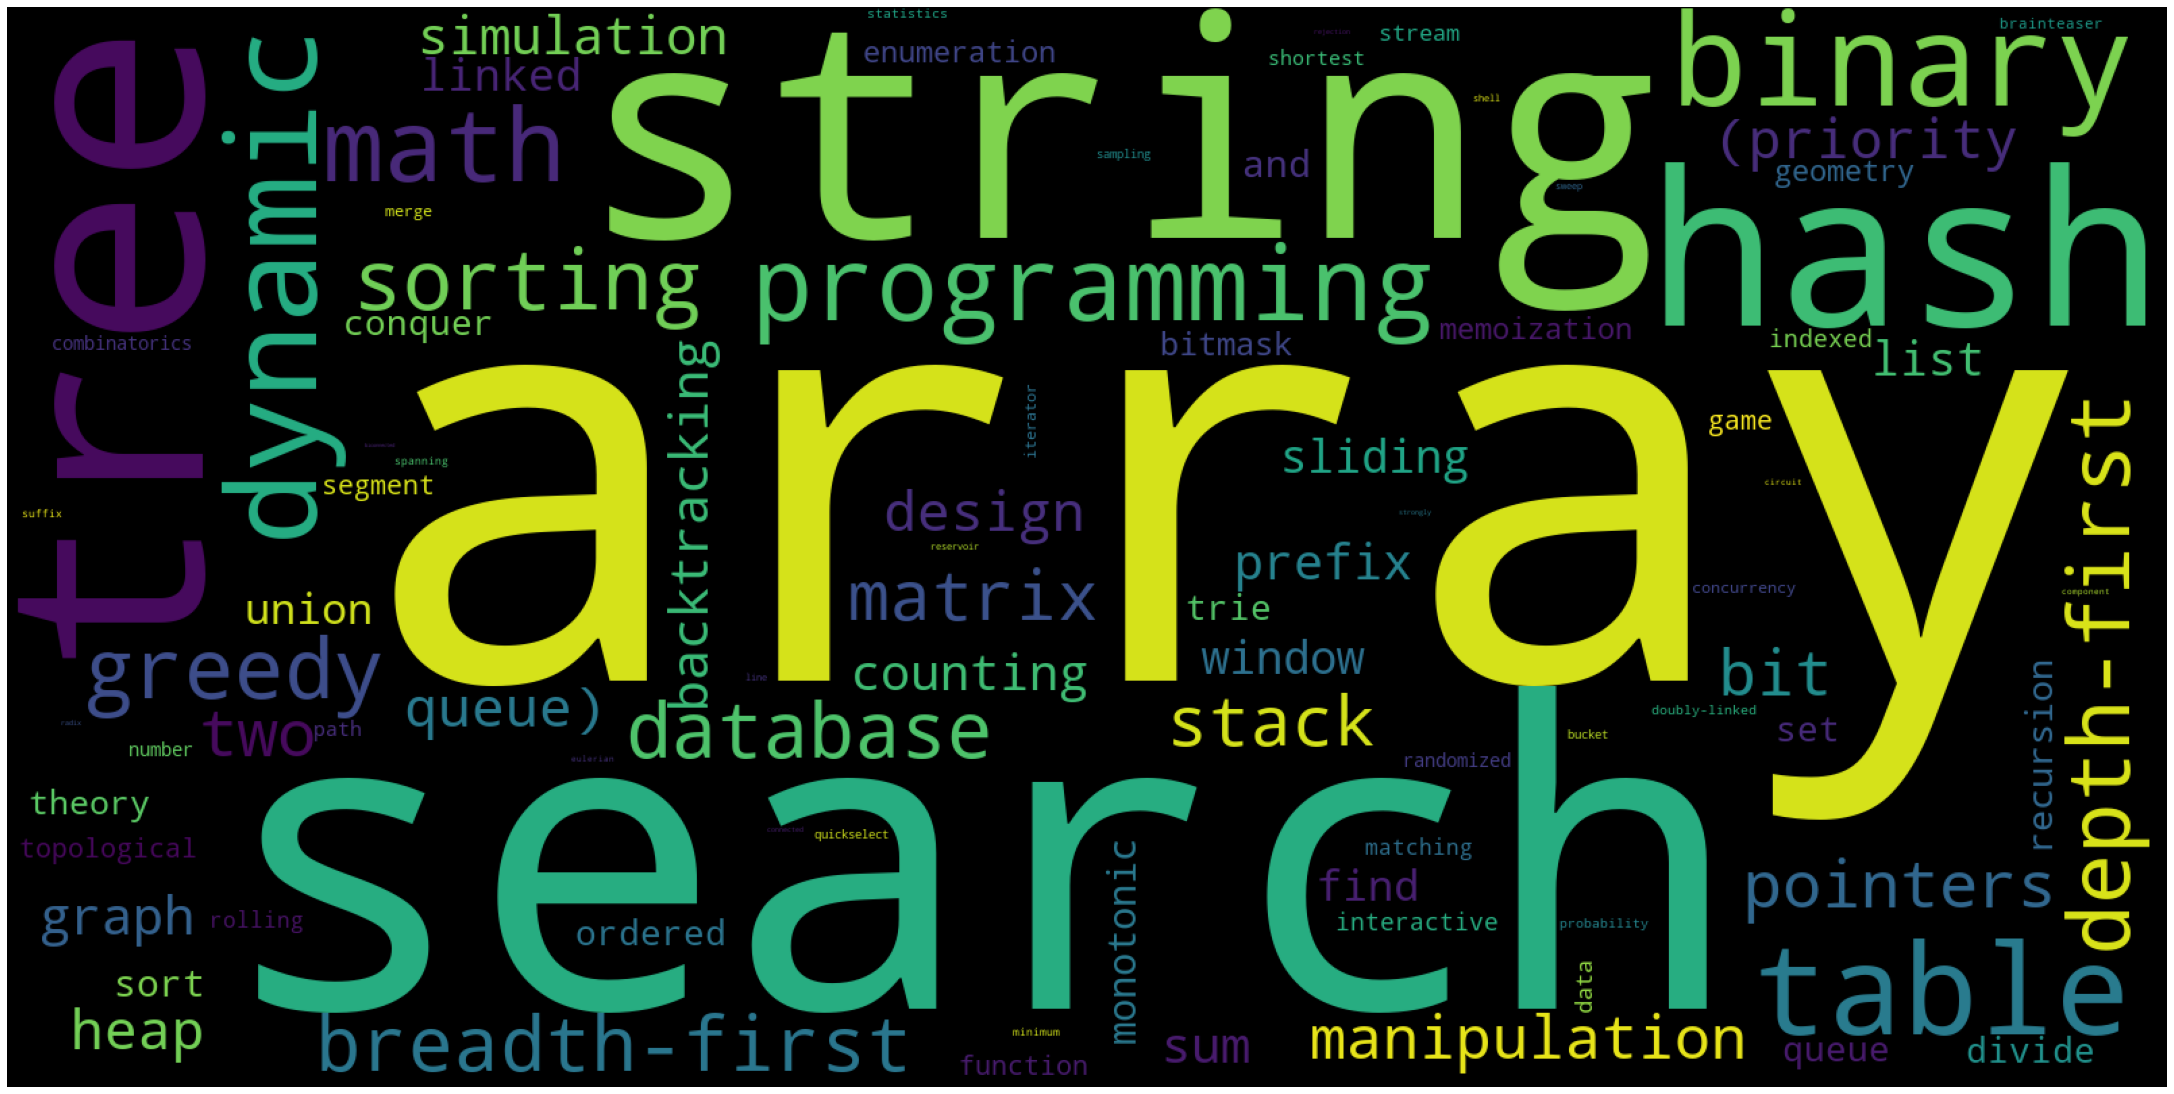

Time taken to run this cell : 0:00:02.502188


In [147]:
#Observation- arrays, searching, hash, binary tree, string are some of the most frequently occuring tags 
from datetime import datetime
from wordcloud import WordCloud
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

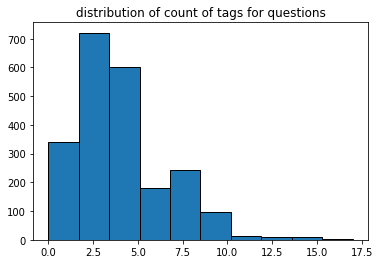

In [148]:
#seems a good distribution 
#count of tags associated with each question
lst = [len(i.split()) for i in df['topic_tags']]
plt.hist(lst, edgecolor = 'black')
plt.title('distribution of count of tags for questions')
plt.show()

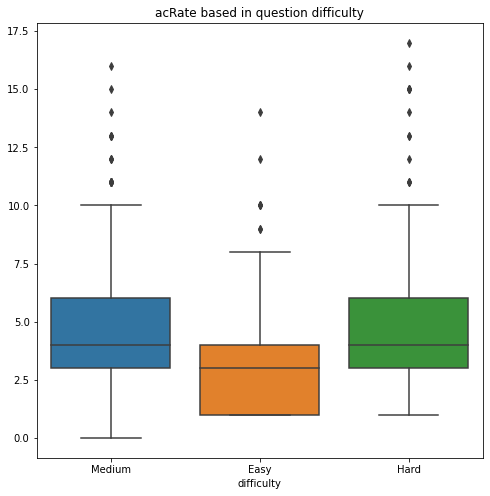

In [149]:
#count of tags based on difficulty level
# observation -  hard and medium questions have more tags attached as they are multiconceptual questions
lst = [len(i.split()) for i in df['topic_tags']]
x = df['difficulty']
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('acRate based in question difficulty')
sns.boxplot(x = x, y = lst, ax=ax)
plt.show()

# Topics

Algorithms     2009
Database        197
Concurrency       9
Shell             4
Name: topic, dtype: int64


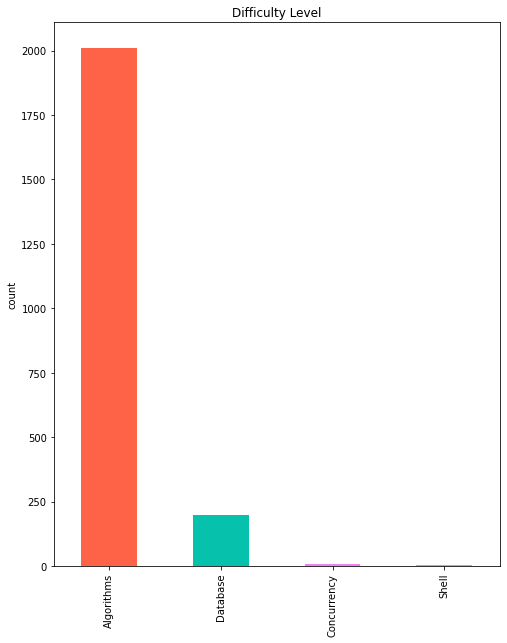

In [150]:
#count of questions of each topic
x = df['topic'].value_counts()
print(x)
colors = ['#FF6347', '#06C2AC','#EE82EE', '#EE82FE' ]
fig_dims = (8, 10)
fig, ax = plt.subplots(figsize=fig_dims)
x.plot(kind = 'bar',
       title = 'Difficulty Level',
       ylabel='count',
       color = colors,
       ax=ax)
plt.show()

[]

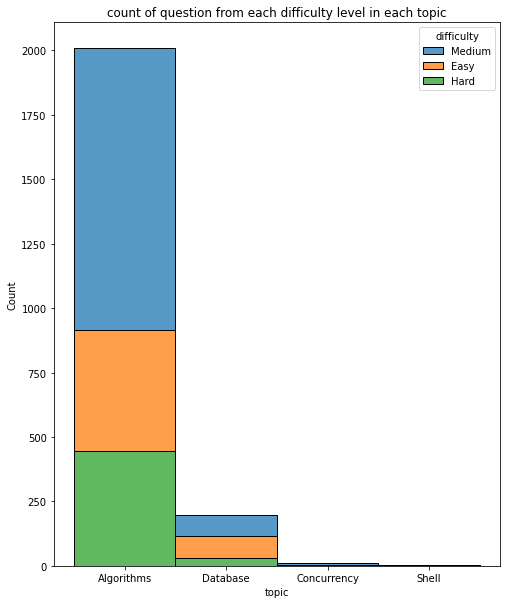

In [151]:
#number of questions from each topic with each difficulty lvl
fig_dims = (8, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(binwidth=0.5, x="topic", hue="difficulty", data=df, stat="count", multiple="stack")
plt.title('count of question from each difficulty level in each topic')
plt.plot()

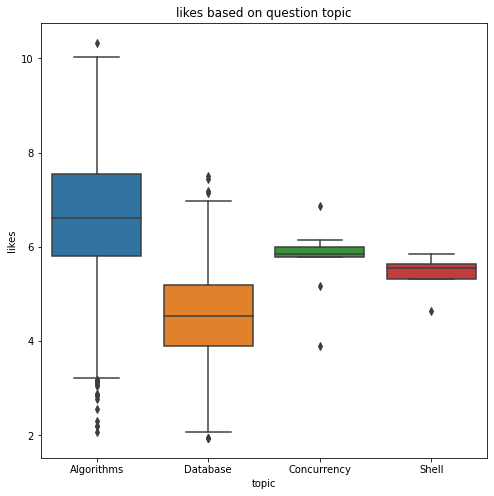

In [152]:
#likes and dislikes based in topic
y =df['likes']
x = df['topic']
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)
plt.title('likes based on question topic')
sns.boxplot(x = x, y =np.log(y), ax=ax)
plt.show()

[]

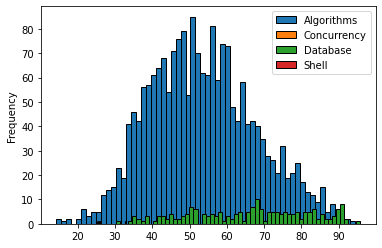

In [153]:
#success rate based on topic
df.groupby('topic')['acRate'].plot(kind='hist', legend=True, edgecolor='Black', bins=60)
plt.plot()

# Titles

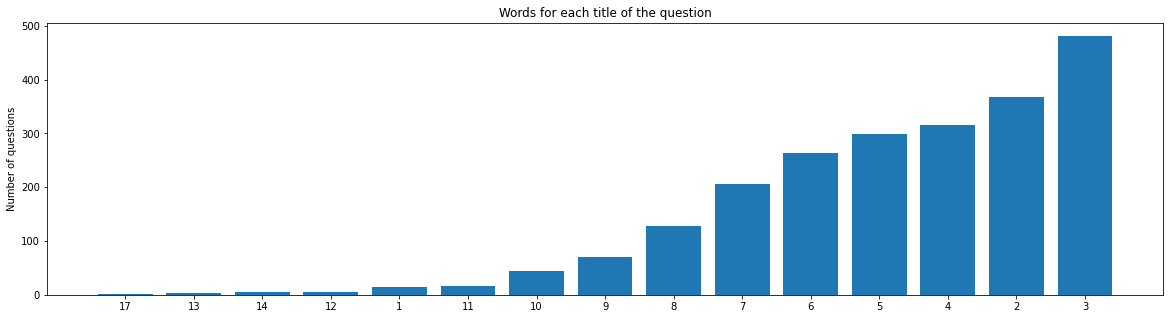

In [154]:
# observation - can be a good feature as we can see some distribution in length of title(the distribution is not very skewed)
#DataFrame: https://stackoverflow.com/a/37483537/4084039
#number of words in title of a question
word_count = df['title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of questions')
plt.title('Words for each title of the question')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [155]:
#not much processing of text is required as most of the text looks clean
#lower case
#remove some punctuation
#printing some question titles randomly
import random
samples = random.sample(range(0, 2000), 100)
for i in samples:
    print(df['title'][i])

Remove Palindromic Subsequences
Biggest Single Number
Basic Calculator III
Sum of Beauty in the Array
Game of Nim
Copy List with Random Pointer
Asteroid Collision
3Sum With Multiplicity
Sum Game
Design an Expression Tree With Evaluate Function
Alphabet Board Path
Letter Combinations of a Phone Number
Group Sold Products By The Date
Check if an Original String Exists Given Two Encoded Strings
Construct Binary Tree from Inorder and Postorder Traversal
Maximum Height by Stacking Cuboids 
Closest Divisors
Sales Analysis III
Find Interview Candidates
Cherry Pickup
Patients With a Condition
Minimum Health to Beat Game
Minimum Cost to Set Cooking Time
Largest Rectangle in Histogram
Convert Binary Search Tree to Sorted Doubly Linked List
Shuffle the Array
Maximize the Confusion of an Exam
Check if All Characters Have Equal Number of Occurrences
Employee Importance
Queries on Number of Points Inside a Circle
Remove Sub-Folders from the Filesystem
Project Employees III
Number of Valid Words in a

# Content

In [156]:
#cleaning is required as the data contains many html tags and unnecessary information which can be removed.
#I will only keep the question text and remove the sample cases/exmaple/explanation in the data
df['content'][6]

'<p>Given the array <code>nums</code>, for each <code>nums[i]</code> find out how many numbers in the array are smaller than it. That is, for each <code>nums[i]</code> you have to count the number of valid <code>j&#39;s</code>&nbsp;such that&nbsp;<code>j != i</code> <strong>and</strong> <code>nums[j] &lt; nums[i]</code>.</p>\n\n<p>Return the answer in an array.</p>\n\n<p>&nbsp;</p>\n<p><strong>Example 1:</strong></p>\n\n<pre>\n<strong>Input:</strong> nums = [8,1,2,2,3]\n<strong>Output:</strong> [4,0,1,1,3]\n<strong>Explanation:</strong> \nFor nums[0]=8 there exist four smaller numbers than it (1, 2, 2 and 3). \nFor nums[1]=1 does not exist any smaller number than it.\nFor nums[2]=2 there exist one smaller number than it (1). \nFor nums[3]=2 there exist one smaller number than it (1). \nFor nums[4]=3 there exist three smaller numbers than it (1, 2 and 2).\n</pre>\n\n<p><strong>Example 2:</strong></p>\n\n<pre>\n<strong>Input:</strong> nums = [6,5,4,8]\n<strong>Output:</strong> [2,1,0,3]\

In [157]:
#content consist of problem statement along with examples and constraints.
#I will only filter the problem statement and remove the examples and constraints.
#  text = '''
# <td><a href="http://www.irit.fr/SC">Signal et Communication</a>
# <br/><a href="http://www.irit.fr/IRT">Ingénierie Réseaux et Télécommunications</a>
# </td>
# '''
#actual quetion after removing tags
v = df['content'][6]
soup = BeautifulSoup(v)

print(soup.get_text())

Given the array nums, for each nums[i] find out how many numbers in the array are smaller than it. That is, for each nums[i] you have to count the number of valid j's such that j != i and nums[j] < nums[i].
Return the answer in an array.
 
Example 1:

Input: nums = [8,1,2,2,3]
Output: [4,0,1,1,3]
Explanation: 
For nums[0]=8 there exist four smaller numbers than it (1, 2, 2 and 3). 
For nums[1]=1 does not exist any smaller number than it.
For nums[2]=2 there exist one smaller number than it (1). 
For nums[3]=2 there exist one smaller number than it (1). 
For nums[4]=3 there exist three smaller numbers than it (1, 2 and 2).

Example 2:

Input: nums = [6,5,4,8]
Output: [2,1,0,3]

Example 3:

Input: nums = [7,7,7,7]
Output: [0,0,0,0]

 
Constraints:

2 <= nums.length <= 500
0 <= nums[i] <= 100




In [158]:
#replace all the null value in content with its corresponding title
df['content'].fillna(df['title'], inplace=True)

# Similar Questions

In [159]:
import json
lst = []
for i in range(len(df)):
    #iterate over each row of dataframe
    df['similar_questions'][i]  = df['similar_questions'][i].replace("'", "")
    #convert it into a list of dict
    df['similar_questions'][i] = json.loads(df['similar_questions'][i])
    lst_title = []
    #iterate over every list of dict
    for j in range(len(df['similar_questions'][i])):
        #extract the titles of similar questions for each question
        title = df['similar_questions'][i][j]['title']
        #store the titles in a list
        lst_title.append(title)
    #append all the list of titles into a single list
    lst.append(lst_title)
#replace value in the original dataframe    
df['similar_questions'] = lst

# Hints

In [160]:
df['hints'][0]

'[]'

In [161]:
for i in range(len(df)):
    #iterate over each row of dataframe convert string representation of list to a list
    df['hints'][i]  = df['hints'][i].replace("'", "")
    #concatenate all the hints
    df['hints'][i]  = ''.join(df['hints'][i])
    #convert concatenated list into string
    df['hints'][i] = df['hints'][i][1:-1]

In [162]:
#there are certain values in hints which are empty lists
df['hints'][2007]

'Did you see a pattern in dividing the number into chunk of words? For example, 123 and 123000., Group the number by thousands (3 digits). You can write a helper function that takes a number less than 1000 and convert just that chunk to words., There are many edge cases. What are some good test cases? Does your code work with input such as 0? Or 1000010? (middle chunk is zero and should not be printed out)'

In [163]:
#replacing all the empty strings with corresponding title value
for i in range(len(df)):
    if df['hints'][i]=='':
        df['hints'][i] = df['title'][i]

# Data Cleaning & Preprocessing

# Titles

In [164]:
#data consist of roman numerals
for i in df['title']:
    if 'Jump Game' in i:
        print(i)

Jump Game
Jump Game III
Jump Game VII
Jump Game II
Jump Game IV
Jump Game VI
Jump Game V


In [165]:
#dict mapping of roman numerals to words
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
val_map={"I": "One", "II": "Two", "III": "Three", 
         "IV": "Four", "V": "Five", "VI": "Six", "VII": "Seven",
          "VIII": "Eight", "IX": "Nine", "X": "Ten"}
#some commonly found stopwords in the titles
stopwords = ['the', 'in', 'of', 'be', 'so', 'a', 'on', 'by', 'can', 'to', 'an', 'as', 'out', 'is', 'are']
preprocessed_title = []
for title in df['title']:
    #map roman numerical to its corresponding word value
    title = ' '.join([val_map.get(i, i) for i in title.split()])
    #lowercase the text
    title = title.lower()
    #remove stop words
    title = ' '.join([stemmer.stem(word) for word in title.split() if word not in stopwords])
    preprocessed_title.append(title)
df['title'] = preprocessed_title

# Content

In [166]:
df['content'][5]

'<p>Given a string <code>s</code>, return <em>the lexicographically smallest subsequence of</em> <code>s</code> <em>that contains all the distinct characters of</em> <code>s</code> <em>exactly once</em>.</p>\n\n<p>&nbsp;</p>\n<p><strong>Example 1:</strong></p>\n\n<pre>\n<strong>Input:</strong> s = &quot;bcabc&quot;\n<strong>Output:</strong> &quot;abc&quot;\n</pre>\n\n<p><strong>Example 2:</strong></p>\n\n<pre>\n<strong>Input:</strong> s = &quot;cbacdcbc&quot;\n<strong>Output:</strong> &quot;acdb&quot;\n</pre>\n\n<p>&nbsp;</p>\n<p><strong>Constraints:</strong></p>\n\n<ul>\n\t<li><code>1 &lt;= s.length &lt;= 1000</code></li>\n\t<li><code>s</code> consists of lowercase English letters.</li>\n</ul>\n\n<p>&nbsp;</p>\n<strong>Note:</strong> This question is the same as 316: <a href="https://leetcode.com/problems/remove-duplicate-letters/" target="_blank">https://leetcode.com/problems/remove-duplicate-letters/</a>'

In [167]:
#content has a lot of html tags
#removing html tags

# https://gist.github.com/sebleier/554280
# punc =  ['!', '()', '-', '[]', '{}', ';', ':','.','?', '@', '#', '$', '%', '^', '&', '*', '_', '~']
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'you',\
            'your', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'also', \
            ]
stemmer = SnowballStemmer("english")

def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentence in tqdm(text_data):
        #removing the html tags
        soup = BeautifulSoup(sentence)
        sent = soup.get_text()
        #keep the question and remove the examples and explanation
        sent = sent.split('Example 1')[0]
        #removing escape sequences
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        #keep only the alpha numericals
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
#        content = ' '.join([word for word in content.split() if word not in punc])
        #remove stop words
        sent = ' '.join(stemmer.stem(e) for e in sent.split() if e.lower() not in stopwords and len(e)!=1)
        #change to lowercase
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text 

preprocessed_content = preprocess_text(df['content'].values)
df['content'] = preprocessed_content

100%|█████████████████████████████████████████████████████████████████████████████| 2219/2219 [00:04<00:00, 515.59it/s]


# Hints

In [168]:
#hints
preprocessed_hints = preprocess_text(df['hints'])
df['hints'] = preprocessed_hints


100%|████████████████████████████████████████████████████████████████████████████| 2219/2219 [00:01<00:00, 2050.08it/s]


In [169]:
df.isnull().sum()

question_id          0
title                0
content              0
difficulty           0
likes                0
dislikes             0
similar_questions    0
topic_tags           0
hints                0
topic                0
totalAccepted        0
totalSubmission      0
acRate               0
dtype: int64

In [171]:
#topic tag has an empty string
#I replaced it by the array as it was present in the title of the question
df['topic_tags'] = df['topic_tags'].replace('', 'Array')

In [173]:
df.to_csv('cleaned_dataset.csv', index=False)